# Detectar arritmias cardíacas mediante señales de ECG parcialmente etiquetadas
### INF395 Introducción a las Redes Neuronales and Deep Learning
- Estudiante: Alessandro Bruno Cintolesi Rodríguez
- ROL: 202173541-0

## **1. Librerias**

In [47]:
# === General / Utilidad ===
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === PyTorch, Torchvision, Torch-audiomentations ===
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchvision
#from torch_audiomentations import Compose, AddColoredNoise, TimeStretch, PitchShift

# === Scikit-learn ===
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, calinski_harabasz_score
from sklearn.cluster import KMeans
from sklearn.utils.class_weight import compute_class_weight

# === Tsaug (Augmentaciones de Series Temporales) ===
from tsaug import TimeWarp, Drift, AddNoise

# === Focal Loss ===
from focal_loss.focal_loss import FocalLoss

## **2. Variables globales**

In [48]:
# Map to class
CLASSES = {
	0: "(N) Latido normal",
	1: "(S) Latido supraventricular",
	2: "(V) Latido ventricular ectópico",
	3: "(F) Latido de fusión",
	4: "(Q) Latido desconocido"
}

# Global variables
SEED = 42
SIGNALS = 186
NUM_WORKERS = 4
BATCH_SIZE = 256
EPOCHS = 50

## **3. Setup del Dispositivo**

In [49]:
# Setup random seed
torch.manual_seed(SEED)
np.random.seed(SEED)

# Setup device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
print("Using device:", DEVICE)
if DEVICE.type == "cuda":
	print("GPU:", torch.cuda.get_device_name(0))

Using device: cuda
GPU: NVIDIA GeForce GTX 1660 Ti with Max-Q Design


## **4. Funciones Auxiliares**

In [50]:
def plot_ecg(X, y, aug=False, aug_title=""):
	y_class = CLASSES.get(y, "Sin clasificar")
	title = f"ECG Clase: {y_class}"
	if aug:
		title = title + f" | {aug_title}"

	plt.plot(X)
	plt.title(title)
	plt.xlabel("Tiempo (muestras)")
	plt.ylabel("Amplitud")
	plt.show()

In [51]:
def plot_clusters(X, clusters, n_clusters):
	for i in range(n_clusters):
		cluster_mask = clusters == i
		cluster_mean = X[cluster_mask].mean(axis=0)
		plt.plot(cluster_mean, label=f"Cluster {i}")

	plt.legend()
	plt.title("Promedio de señal por cluster")
	plt.xlabel("Muestra")
	plt.ylabel("Amplitud promedio")
	plt.grid(True)
	plt.show()

## **5. Analisis Exploratorio de Datos**

In [52]:
# Read our train and test CSV
train_df = pd.read_csv("ecg_signals/train_semi_supervised.csv")
test_df = pd.read_csv("ecg_signals/test_semi_supervised.csv")

In [53]:
# Dividimos nuestros datos en X (serie de tiempo) / y (label)
X_train = train_df.iloc[:, :-1].values
y_train = train_df.iloc[:, -1].values

X_test = test_df.iloc[:, :-1].values
y_test = test_df.iloc[:, -1].values

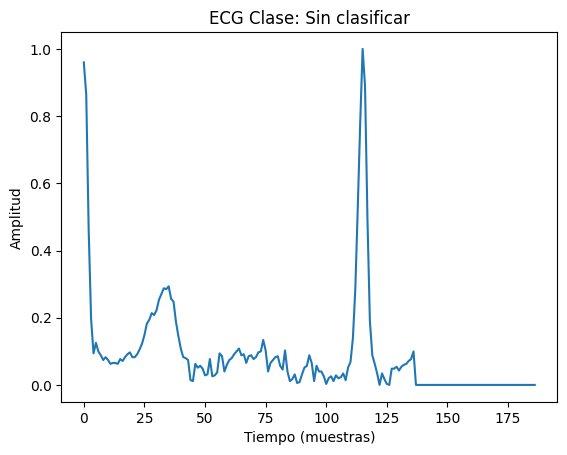

In [54]:
# Graficando un ECG
plot_ecg(X=X_train[1], y=y_train[1])

In [55]:
# Clusters con K-means
train_kmeans = KMeans(n_clusters=5, random_state=SEED)
train_clusters = train_kmeans.fit_predict(X_train)

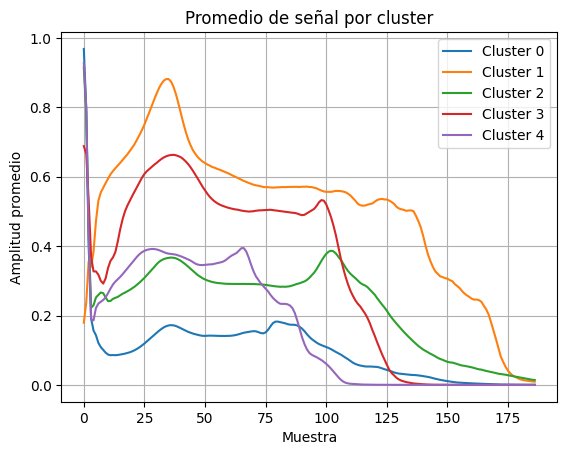

In [56]:
plot_clusters(X=X_train, clusters=train_clusters, n_clusters=5)

In [57]:
# Hacemos un conteo por clases
unique, counts = np.unique(y_train, return_counts=True)
for c, n in zip(unique, counts):
	if not np.isnan(c):
		c = int(c)
	print(f"Clase {c}: {n} muestras ({n/len(y_train)*100:.2f}%)")

Clase 0: 36236 muestras (41.39%)
Clase 1: 1112 muestras (1.27%)
Clase 2: 2894 muestras (3.31%)
Clase 3: 321 muestras (0.37%)
Clase 4: 3216 muestras (3.67%)
Clase nan: 43775 muestras (50.00%)


In [58]:
n_classes = 5

y_valid = y_train[~np.isnan(y_train)]
y_valid = y_valid[y_valid >= 0].astype(int)

print("Clases en y_valid:", np.unique(y_valid))

present_classes = np.unique(y_valid)
weights_partial = compute_class_weight(
	class_weight="balanced",
	classes=present_classes,
	y=y_valid
)

full_weights = np.zeros(n_classes, dtype=np.float32)
for c, w in zip(present_classes, weights_partial):
	full_weights[int(c)] = float(w)

class_weights = torch.tensor(full_weights, dtype=torch.float32).to(DEVICE)
print("Pesos por clase (0..4):", class_weights.cpu().numpy())

Clases en y_valid: [0 1 2 3 4]
Pesos por clase (0..4): [ 0.24163263  7.873921    3.025501   27.276636    2.7225747 ]


## **6. SimCLR**

### **6.1 Augmentaciones para SimCLR**

#### **6.1.a Augmentaciones para SimCLR utilizando Tsaug**

In [59]:
tsaug_augmenter = (
	TimeWarp(n_speed_change=3, max_speed_ratio=2.0)
	+ Drift(max_drift=(0.1, 0.3))
	+ AddNoise(scale=0.01)
)

def simclr_tsaug_augmentation(x):
	aug1 = tsaug_augmenter.augment(x[np.newaxis, ...])[0]
	aug2 = tsaug_augmenter.augment(x[np.newaxis, ...])[0]
	return aug1, aug2

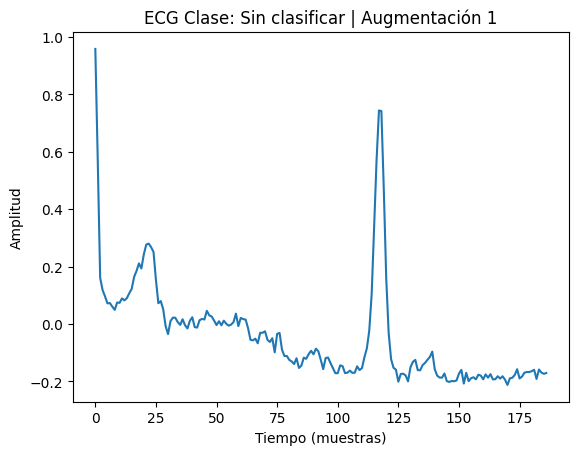

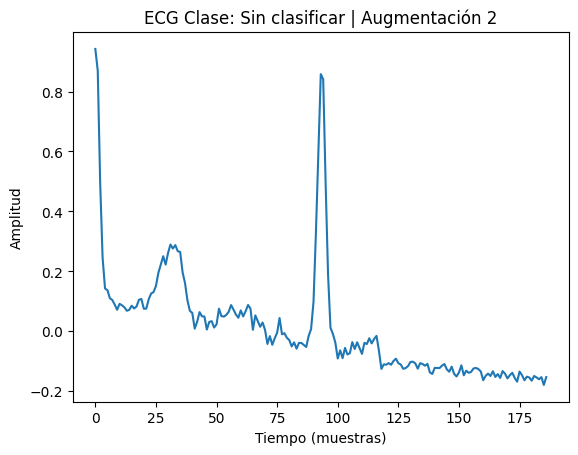

In [60]:
aug1, aug2 = simclr_tsaug_augmentation(X_train[1])
plot_ecg(X=aug1, y=y_train[1], aug=True, aug_title="Augmentación 1")
plot_ecg(X=aug2, y=y_train[1], aug=True, aug_title="Augmentación 2")

#### **6.1.b Augmentaciones para SimCLR utilizando torch-audiomentations**

In [61]:
"""
torchaudio_augmenter = Compose([
	AddColoredNoise(p=0.5),
	TimeStretch(min_rate=0.8, max_rate=1.2, p=0.5),
	PitchShift(min_transpose_semitones=-2, max_transpose_semitones=2, p=0.5)
])

def simclr_tsaug_augmentation(x):
	aug1 = torchaudio_augmenter.augment(x)
	aug2 = torchaudio_augmenter.augment(x)
	return aug1, aug2
"""

'\ntorchaudio_augmenter = Compose([\n\tAddColoredNoise(p=0.5),\n\tTimeStretch(min_rate=0.8, max_rate=1.2, p=0.5),\n\tPitchShift(min_transpose_semitones=-2, max_transpose_semitones=2, p=0.5)\n])\n\ndef simclr_tsaug_augmentation(x):\n\taug1 = torchaudio_augmenter.augment(x)\n\taug2 = torchaudio_augmenter.augment(x)\n\treturn aug1, aug2\n'